In [5]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from sklearn.cross_validation import train_test_split
from models.cascade_base import CascadeBase
from utils.visualizer import Visualizer
from IPython.display import SVG, display

import numpy as np
import matplotlib.pyplot as plt

import time
import pydot
import lasagne

plt.style.use('ggplot')

%matplotlib inline

In [7]:
def get_hex_color(layer_type):
    """
    Determines the hex color for a layer.
    :parameters:
        - layer_type : string
            Class name of the layer
    :returns:
        - color : string containing a hex color for filling block.
    """
    COLORS = ['#4A88B3', '#98C1DE', '#6CA2C8', '#3173A2', '#17649B',
              '#FFBB60', '#FFDAA9', '#FFC981', '#FCAC41', '#F29416',
              '#C54AAA', '#E698D4', '#D56CBE', '#B72F99', '#B0108D',
              '#75DF54', '#B3F1A0', '#91E875', '#5DD637', '#3FCD12']

    hashed = int(hash(layer_type)) % 5

    if "conv" in layer_type.lower():
        return COLORS[:5][hashed]
    if layer_type in lasagne.layers.pool.__all__:
        return COLORS[5:10][hashed]
    if layer_type in lasagne.layers.recurrent.__all__:
        return COLORS[10:15][hashed]
    else:
        return COLORS[15:20][hashed]

def make_pydot_graph(layers, output_shape=True, verbose=False):
    """
    :parameters:
        - layers : list
            List of the layers, as obtained from lasagne.layers.get_all_layers
        - output_shape: (default `True`)
            If `True`, the output shape of each layer will be displayed.
        - verbose: (default `False`)
            If `True`, layer attributes like filter shape, stride, etc.
            will be displayed.
    :returns:
        - pydot_graph : PyDot object containing the graph
    """

    pydot_graph = pydot.Dot('Network', graph_type='digraph')
    pydot_nodes = {}
    pydot_edges = []
    for i, layer in enumerate(layers):
        layer_type = '{0}'.format(layer.__class__.__name__)
        layer_name = layer.name if layer.name is not None else ''
        key = repr(layer)
        label = layer_name + ' ' + layer_type
        color = get_hex_color(layer_type)
        if verbose:
            for attr in ['num_filters', 'num_units', 'ds',
                         'filter_shape', 'stride', 'strides', 'p']:
                if hasattr(layer, attr):
                    label += '\n{0}: {1}'.format(attr, getattr(layer, attr))
            if hasattr(layer, 'nonlinearity'):
                try:
                    nonlinearity = layer.nonlinearity.__name__
                except AttributeError:
                    nonlinearity = layer.nonlinearity.__class__.__name__
                label += '\nnonlinearity: {0}'.format(nonlinearity)

        if output_shape:
            label += '\nOutput shape: {0}'.format(layer.output_shape)

        pydot_nodes[key] = pydot.Node(
            key, label=label, shape='record', fillcolor=color, style='filled')

        if hasattr(layer, 'input_layers'):
            for input_layer in layer.input_layers:
                pydot_edges.append([repr(input_layer), key])

        if hasattr(layer, 'input_layer'):
            pydot_edges.append([repr(layer.input_layer), key])

    for node in pydot_nodes.values():
        pydot_graph.add_node(node)

    for edges in pydot_edges:
        pydot_graph.add_edge(
            pydot.Edge(pydot_nodes[edges[0]], pydot_nodes[edges[1]]))
    return pydot_graph


def iterate_minibatches(inputs, targets, batch_size):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]

        yield inputs[excerpt], targets[excerpt]


def learn(nn,
          dataset,
          watches=['obj',
                   'recall',
                   'precision',
                   'accuracy',
                   'loss',
                   'sub_loss'],
          num_epochs=100,
          batch_size=50):
    '''
        num_epochs - amount of passes through the data
        batch_size - number of samples processed at each function call
        dataset - [X_train, X_val, y_train, y_val]
    '''
    %matplotlib notebook
    
    X_train, X_val, y_train, y_val = dataset
    metrics_template = dict()
    
    metrics_sample = nn.evaluate(X_val[:2], y_val[:2])
    
    for metric_name, _ in metrics_sample.items():
        if metric_name == 'complexity_parts':
            metrics_template[metric_name] = [0] * len(metrics_sample[metric_name])
        else:
            metrics_template[metric_name] = 0
        
    visualizer = Visualizer(num_epochs,
                            metrics_template,
                            watches=watches)
    
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        
        train_measurements = dict(metrics_template)
        train_batches = 0

        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.train(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        train_measurements[metric_name][j] += metric[j]
                else: 
                    train_measurements[metric_name] += metric

            train_batches += 1
            
        for metric_name, metric in train_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    train_measurements[metric_name][j] = metric[j] / train_batches
            else: 
                train_measurements[metric_name] = metric / train_batches

        # And a full pass over the validation data:
        val_measurements = dict(metrics_template)
        val_batches = 0

        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            
            for metric_name, metric in nn.evaluate(inputs, targets).items():
                if metric_name == 'complexity_parts':
                    for j in range(len(metrics_template[metric_name])):
                        val_measurements[metric_name][j] += metric[j]
                else: 
                    val_measurements[metric_name] += metric

            val_batches += 1
            
        for metric_name, metric in val_measurements.items():
            if metric_name == 'complexity_parts':
                for j in range(len(metrics_template[metric_name])):
                    val_measurements[metric_name][j] = metric[j] / val_batches
            else: 
                val_measurements[metric_name] = metric / val_batches

        print('Epoch {} of {} took {:.3f}s'.format(epoch + 1, num_epochs, time.time() - start_time))
        visualizer.watch(train_measurements, val_measurements)
    visualizer.finish()
    
def draw(network):
    with open('../images/net.svg', 'w') as f:
        g = make_pydot_graph(lasagne.layers.get_all_layers(network))
        f.write(g.create_svg(f='svg'))

    display(SVG(filename='../images/net.svg'))

In [4]:
dataset = np.load('../data/X.npy')
targets = np.load('../data/targets.npy')

In [5]:
X_y = train_test_split(dataset.reshape(-1, 1, 200, 200).astype(np.float32),
                       targets.reshape(-1, 1, 200, 200).astype(np.float32))

# Simple network

In [4]:
network = CascadeBase(img_shape=(200, 200),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=0,
                      c_sub_objs=[0, 0, 0],
                      c_sub_obj_cs=[0, 0, 0],
                      mul=False,
                      pool_sizes=[2, 2, 2],
                      num_filters=[1, 1, 3],
                      filter_sizes=[1, 3, 3],
                      l2_c=1e-4)

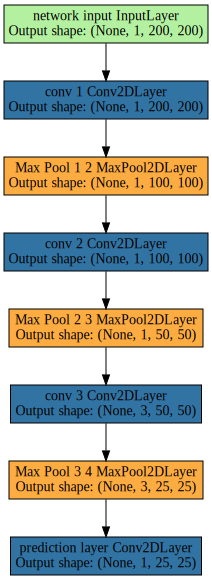

In [5]:
draw(network.output_layer)

/home/apanin/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>


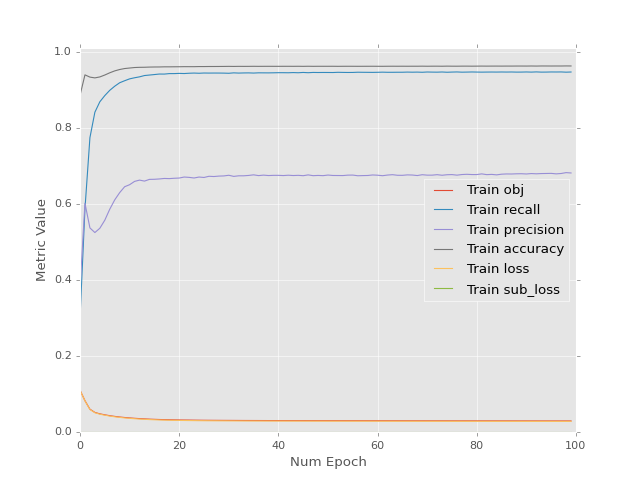

<IPython.core.display.Javascript object>


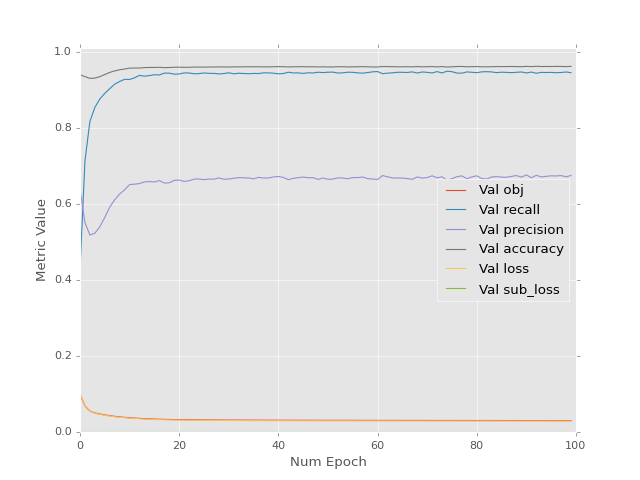

<IPython.core.display.Javascript object>


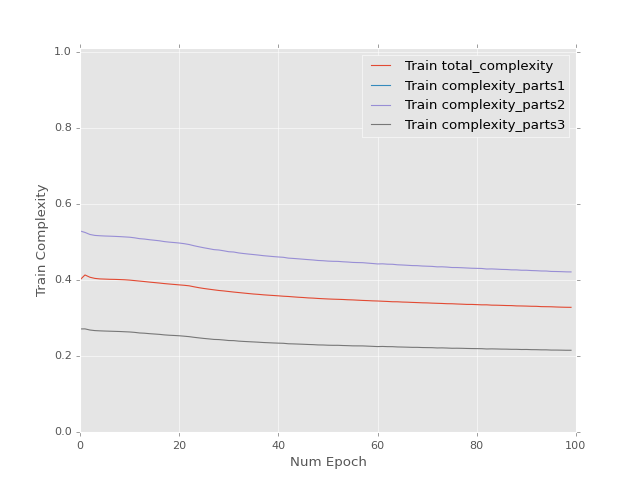

<IPython.core.display.Javascript object>


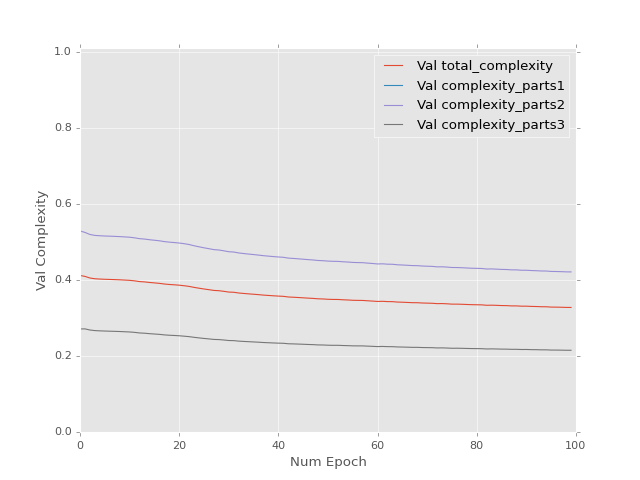

Epoch 1 of 100 took 22.598s


/home/apanin/anaconda/lib/python2.7/site-packages/matplotlib/backends/backend_webagg_core.py:210: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  buff.shape = (renderer.height, renderer.width)


Epoch 2 of 100 took 22.478s
Epoch 3 of 100 took 22.567s
Epoch 4 of 100 took 22.756s
Epoch 5 of 100 took 22.662s
Epoch 6 of 100 took 22.672s
Epoch 7 of 100 took 22.725s
Epoch 8 of 100 took 22.873s
Epoch 9 of 100 took 22.935s
Epoch 10 of 100 took 22.964s
Epoch 11 of 100 took 23.035s
Epoch 12 of 100 took 22.922s
Epoch 13 of 100 took 22.917s
Epoch 14 of 100 took 23.227s
Epoch 15 of 100 took 23.121s
Epoch 16 of 100 took 22.916s
Epoch 17 of 100 took 22.935s
Epoch 18 of 100 took 22.909s
Epoch 19 of 100 took 22.945s
Epoch 20 of 100 took 23.003s
Epoch 21 of 100 took 22.879s
Epoch 22 of 100 took 22.900s
Epoch 23 of 100 took 22.904s
Epoch 24 of 100 took 22.933s
Epoch 25 of 100 took 22.956s
Epoch 26 of 100 took 22.910s
Epoch 27 of 100 took 22.907s
Epoch 28 of 100 took 22.918s
Epoch 29 of 100 took 22.896s
Epoch 30 of 100 took 22.909s
Epoch 31 of 100 took 22.904s
Epoch 32 of 100 took 22.895s
Epoch 33 of 100 took 22.907s
Epoch 34 of 100 took 22.884s
Epoch 35 of 100 took 22.964s
Epoch 36 of 100 took 2

In [8]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=100,
      batch_size=50)

# Improved network

## Sub objs

In [9]:
network = CascadeBase(img_shape=(200, 200),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=0,
                      c_sub_objs=[1e-2, 5e-2, 1e-1],
                      c_sub_obj_cs=[1e-3, 5e-3, 1e-2],
                      mul=False,
                      pool_sizes=[2, 2, 2],
                      num_filters=[1, 1, 3],
                      filter_sizes=[1, 3, 3])

<IPython.core.display.Javascript object>


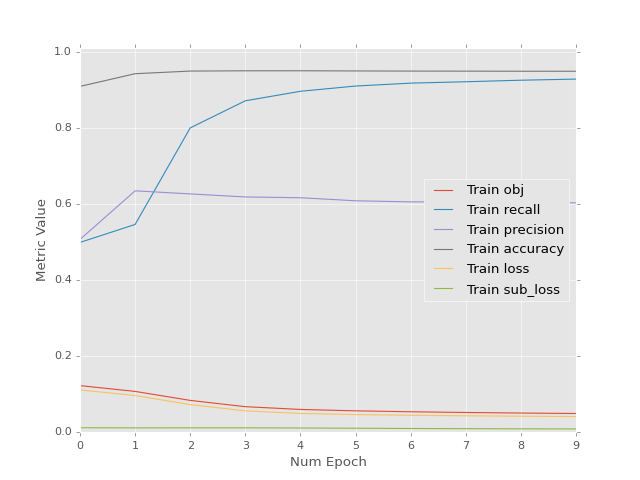

<IPython.core.display.Javascript object>


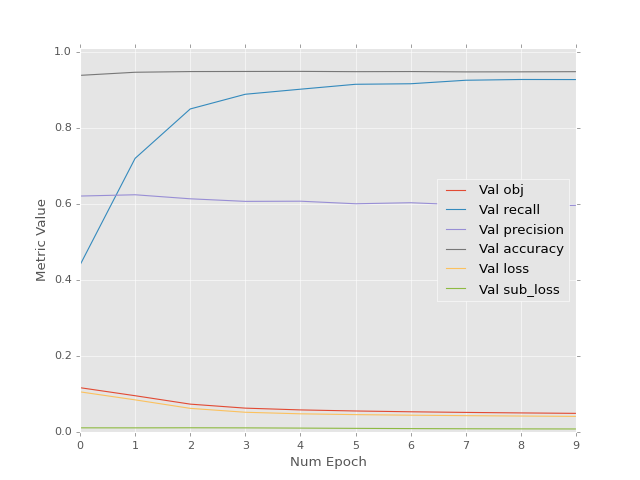

<IPython.core.display.Javascript object>


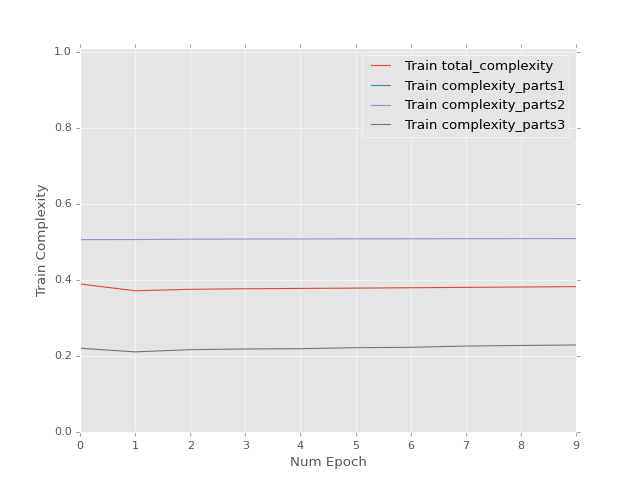

<IPython.core.display.Javascript object>


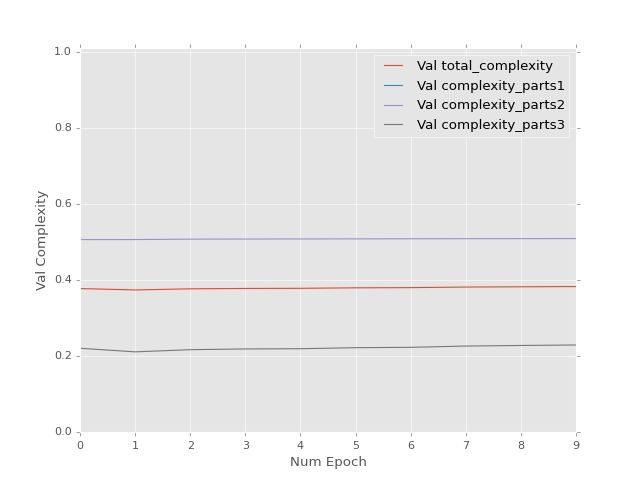

Epoch 1 of 10 took 25.427s
Epoch 2 of 10 took 25.302s
Epoch 3 of 10 took 25.472s
Epoch 4 of 10 took 25.512s
Epoch 5 of 10 took 26.074s
Epoch 6 of 10 took 25.546s
Epoch 7 of 10 took 25.657s
Epoch 8 of 10 took 25.536s
Epoch 9 of 10 took 25.545s
Epoch 10 of 10 took 25.825s


In [10]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=10,
      batch_size=50)

In [11]:
network.save('../weights', 'small_sub_obj')

## Increase importance of sub_obj and add multiplication

In [15]:
network = CascadeBase(img_shape=(200, 200),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=0,
                      c_sub_objs=[1e-2, 5e-2, 1e-1],
                      c_sub_obj_cs=[1e-3, 5e-3, 1e-2],
                      mul=True,
                      pool_sizes=[2, 2, 2],
                      num_filters=[1, 1, 3],
                      filter_sizes=[1, 3, 3])

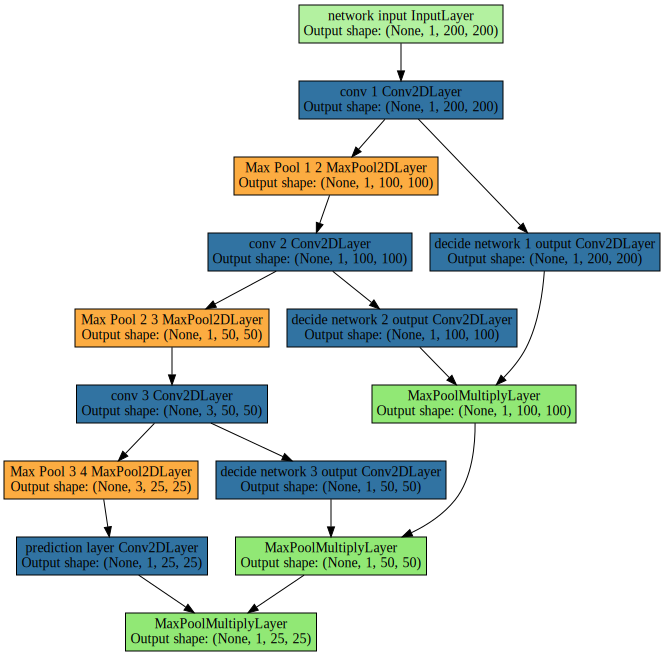

In [9]:
draw(network.output_layer)

In [16]:
network.load('../weights', 'small_sub_obj')

<IPython.core.display.Javascript object>


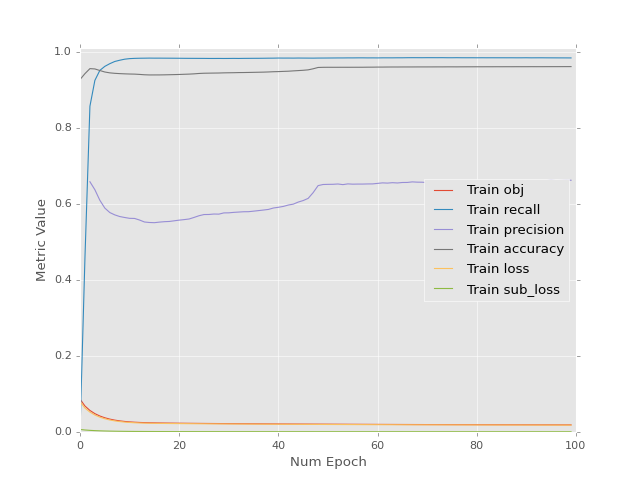

<IPython.core.display.Javascript object>


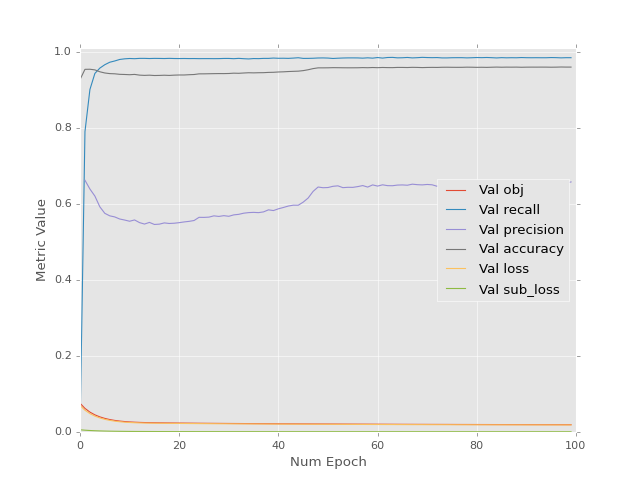

<IPython.core.display.Javascript object>


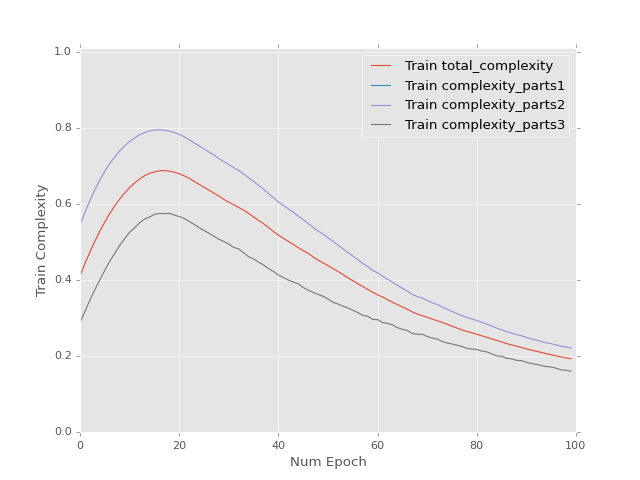

<IPython.core.display.Javascript object>


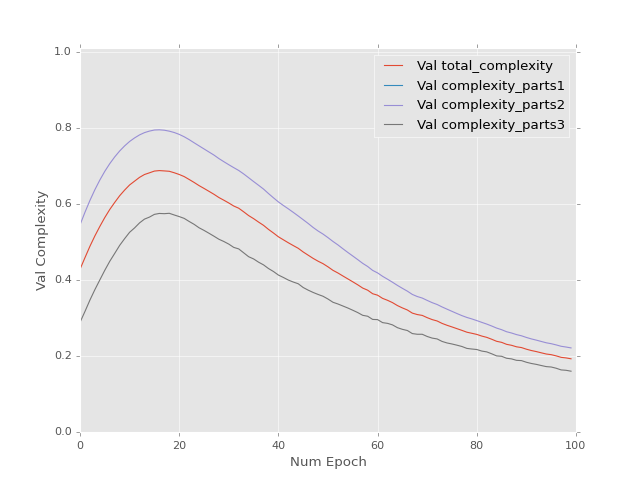

Epoch 1 of 100 took 37.058s
Epoch 2 of 100 took 37.244s
Epoch 3 of 100 took 37.297s
Epoch 4 of 100 took 37.538s
Epoch 5 of 100 took 37.918s
Epoch 6 of 100 took 38.119s
Epoch 7 of 100 took 38.019s
Epoch 8 of 100 took 38.140s
Epoch 9 of 100 took 38.230s
Epoch 10 of 100 took 38.207s
Epoch 11 of 100 took 38.565s
Epoch 12 of 100 took 38.241s
Epoch 13 of 100 took 38.068s
Epoch 14 of 100 took 38.143s
Epoch 15 of 100 took 37.982s
Epoch 16 of 100 took 37.945s
Epoch 17 of 100 took 37.929s
Epoch 18 of 100 took 38.024s
Epoch 19 of 100 took 37.884s
Epoch 20 of 100 took 38.008s
Epoch 21 of 100 took 38.086s
Epoch 22 of 100 took 37.802s
Epoch 23 of 100 took 37.831s
Epoch 24 of 100 took 37.966s
Epoch 25 of 100 took 37.888s
Epoch 26 of 100 took 37.755s
Epoch 27 of 100 took 38.092s
Epoch 28 of 100 took 37.856s
Epoch 29 of 100 took 37.841s
Epoch 30 of 100 took 38.125s
Epoch 31 of 100 took 37.822s
Epoch 32 of 100 took 37.867s
Epoch 33 of 100 took 37.919s
Epoch 34 of 100 took 37.798s
Epoch 35 of 100 took 37

In [17]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=100,
      batch_size=50)

In [18]:
network.save('../weights', 'mul_bigger_sub_obj')

## Add complexity and increase importance

In [19]:
network = CascadeBase(img_shape=(200, 200),
                      learning_rate=1e-3,
                      c=1e-1,
                      c_complexity=1,
                      c_sub_objs=[5e-2, 1e-1, 1e-1],
                      c_sub_obj_cs=[1e-2, 5e-2, 1e-1],
                      mul=True,
                      pool_sizes=[2, 2, 2],
                      num_filters=[1, 1, 3],
                      filter_sizes=[1, 3, 3])

In [20]:
network.load('../weights', 'mul_bigger_sub_obj')

<IPython.core.display.Javascript object>


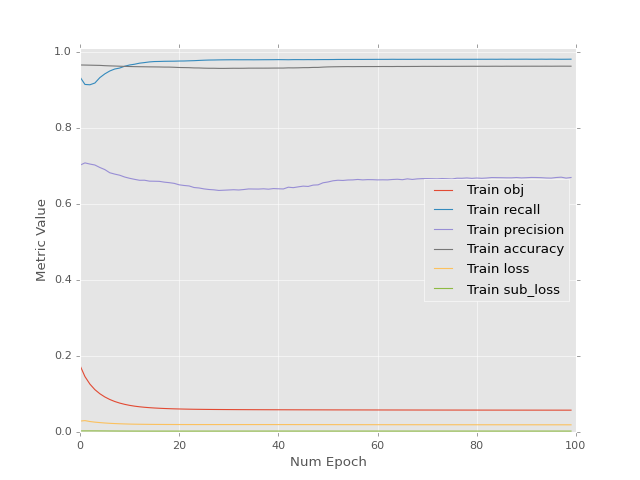

<IPython.core.display.Javascript object>


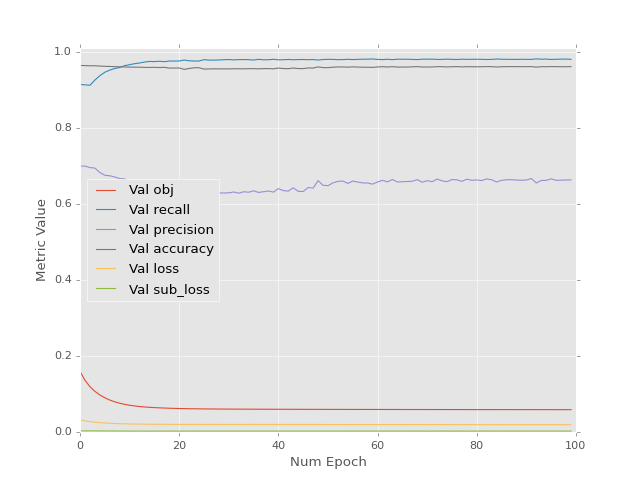

<IPython.core.display.Javascript object>


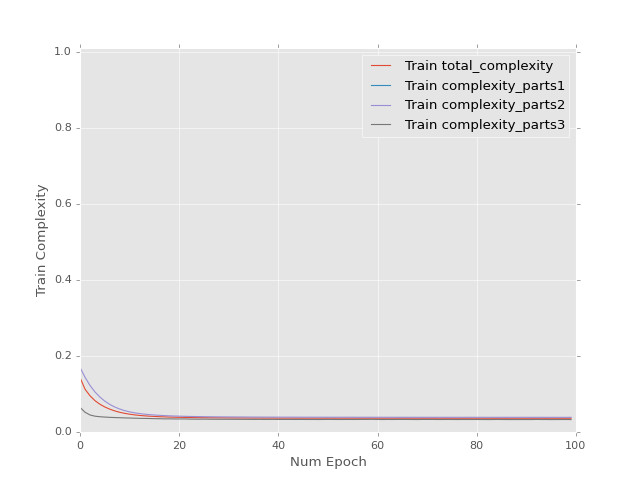

<IPython.core.display.Javascript object>


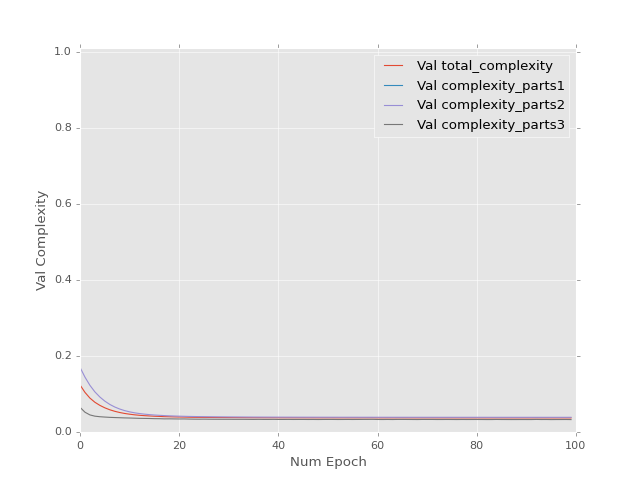

Epoch 1 of 100 took 37.086s
Epoch 2 of 100 took 36.747s
Epoch 3 of 100 took 36.852s
Epoch 4 of 100 took 37.124s
Epoch 5 of 100 took 37.672s
Epoch 6 of 100 took 37.689s
Epoch 7 of 100 took 37.762s
Epoch 8 of 100 took 37.672s
Epoch 9 of 100 took 37.774s
Epoch 10 of 100 took 37.833s
Epoch 11 of 100 took 37.868s
Epoch 12 of 100 took 37.945s
Epoch 13 of 100 took 37.813s
Epoch 14 of 100 took 37.729s
Epoch 15 of 100 took 37.713s
Epoch 16 of 100 took 37.751s
Epoch 17 of 100 took 37.668s
Epoch 18 of 100 took 37.645s
Epoch 19 of 100 took 37.763s
Epoch 20 of 100 took 38.157s
Epoch 21 of 100 took 37.922s
Epoch 22 of 100 took 37.816s
Epoch 23 of 100 took 37.686s
Epoch 24 of 100 took 37.553s
Epoch 25 of 100 took 37.724s
Epoch 26 of 100 took 37.594s
Epoch 27 of 100 took 37.639s
Epoch 28 of 100 took 37.552s
Epoch 29 of 100 took 37.621s
Epoch 30 of 100 took 37.588s
Epoch 31 of 100 took 37.641s
Epoch 32 of 100 took 37.691s
Epoch 33 of 100 took 37.617s
Epoch 34 of 100 took 37.830s
Epoch 35 of 100 took 37

In [21]:
learn(network,
      X_y,
      watches=['obj',
               'recall',
               'precision',
               'accuracy',
               'loss',
               'sub_loss',
               'total_complexity',
               'complexity_parts'],
      num_epochs=100,
      batch_size=50)

In [80]:
network.save('../weights', 'mul_big_sub_obj_complex')

# Check results

In [22]:
def check_results():
    %matplotlib inline
    i = np.random.choice(X_y[1].shape[0])

    plt.imshow(X_y[1][i].reshape((200, 200)))
    plt.colorbar()
    plt.show()

    plt.imshow(X_y[-1][i].reshape((200, 200)), interpolation='none')
    plt.show()

    prediction = network.predict(X_y[1][i].reshape((1, 1, 200, 200)).astype(np.float32))

    plt.imshow(prediction[0, 0], interpolation='none', cmap=plt.cm.Reds)
    plt.colorbar()
    plt.show()

    plt.imshow(prediction[0, 0] < 0.5, interpolation='none', cmap=plt.cm.Reds)
    plt.colorbar()
    plt.show()

    plt.imshow(prediction[0, 0] >= 0.5, interpolation='none', cmap=plt.cm.Reds)
    plt.colorbar()
    plt.show()

/home/apanin/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


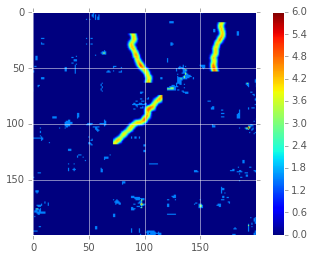

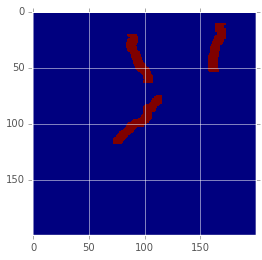

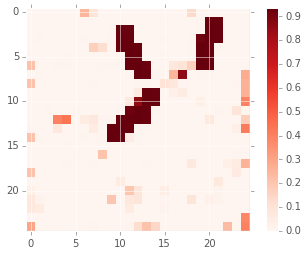

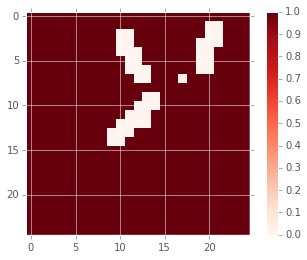

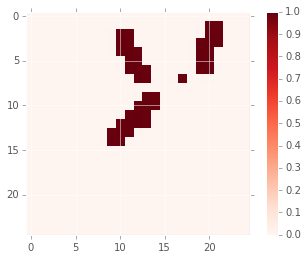

In [23]:
check_results()

In [24]:
layers = lasagne.layers.get_all_layers(network.output_layer)

<matplotlib.colorbar.Colorbar instance at 0x7f6fbafe8d40>

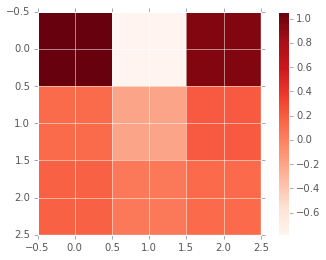

In [25]:
params = lasagne.layers.get_all_param_values(layers[3])
plt.imshow(params[-2][0, 0], interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()

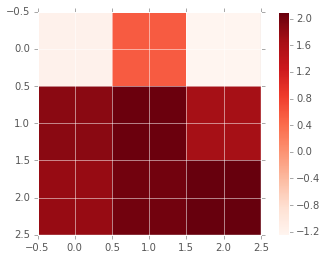

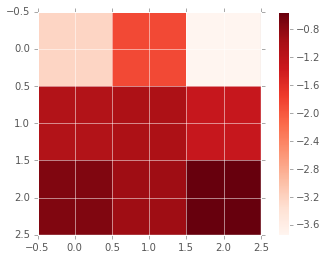

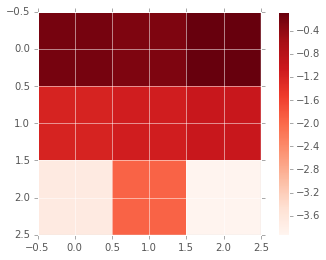

In [26]:
params = lasagne.layers.get_all_param_values(layers[5])
for param in params[-2]:
    plt.imshow(param[0], interpolation='none', cmap=plt.cm.Reds)
    plt.colorbar()
    plt.show()